In [52]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [53]:
# отключение предупреждений об ошибке
import warnings
warnings.filterwarnings('ignore')

### Общая информация
Дата выдачи: 24.05.2016

Срок сдачи: 23:59 31.05.2016

Максимальная оценка за задание: 10 баллов.

Пожалуйста, указывайте тему письма в формате «[ИАД-16] HW6, ФИО».

### Данные

С помощью решающих деревьев и случайных лесов мы будем оценивать качество вина. Csv-файл с данными доступен по [ссылке](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv).

Целевой признак — quality, так что нас ждёт задача мультиклассовой классификации.

#### Часть I. Готовим данные.

**1.** Загрузите данные и запишите их в датафрейм all_wine, выведите пять первых записей с помощью head. Узнайте, какие значения принимает целевой признак quality. Посмотрите, есть ли пропуски в данных?

In [54]:
# your code here
all_wine = pd.read_csv('winequality-red.csv', sep=';')
all_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [55]:
# your code here
print('Значения целевого признака:', all_wine['quality'].unique())
if(all_wine.shape == all_wine.dropna().shape):
    print("Пропусков нет")
else:
    print("Есть пропуски")

Значения целевого признака: [5 6 7 4 8 3]
Пропусков нет


**2.** Посчитайте число объектов каждого класса в выборке. Есть ли классы, в которых особенно мало объектов? Их можно удалить или объединить с «соседними» классами. Удалите объекты классов, объекты которых встречаются меньше 15 раз.

In [56]:
# your code here
# кол-во объектов каждого класса
print('Количество встречающихся экземпляров одного класса в данных')
print(all_wine['quality'].value_counts())

Количество встречающихся экземпляров одного класса в данных
5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64


In [57]:
# your code here
# удаляем редкие классы
all_wine = all_wine[all_wine.quality != 3]

**3.** Разбейте выборку в отношении 7 к 3 на train и test, предварительно перемешав. Матрицы объекты×признаки назовите X_train, X_test, а целевой вектор — y_train, y_test соответственно.

In [58]:
from sklearn.cross_validation import train_test_split

# your code here
# отделяем от выборки вектор ответов
X = all_wine.drop('quality', 1)
y = all_wine['quality']

In [59]:
# формируем матрицы объекты-признаки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Часть II. Исследование параметров случайных лесов

**4.** Для начала обучите Random Forest с параметрами по умолчанию, посчитайте ошибку на тестовой выборке по F-мере (используйте average='weighted').

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# your code here
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_predict = rfc.predict(X_test)

f1_scr = f1_score(y_test, rfc_predict, average="weighted")
print("f1_score:", f1_scr)

f1_score: 0.63800540312


**5.** Постройте оценки важности признаков, попробуйте удалить самые неважные и проверить, улучшилось ли качество.

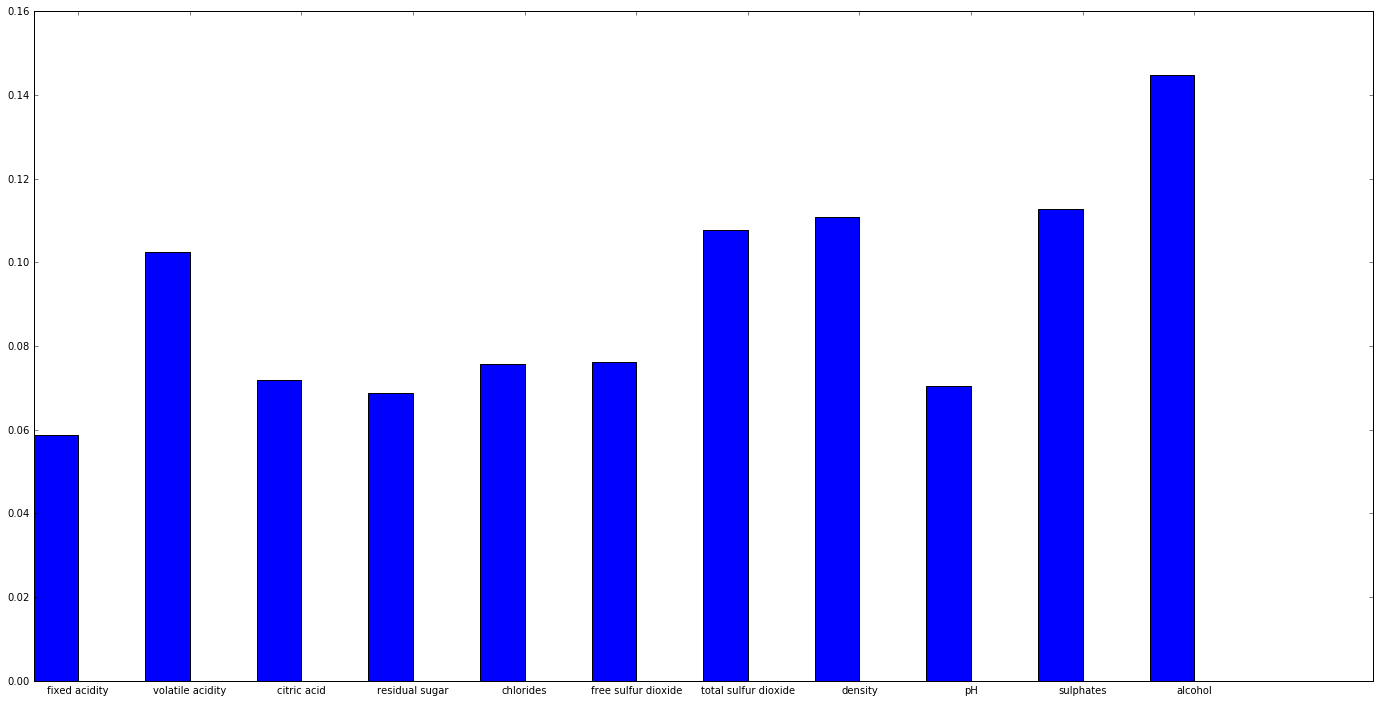

In [61]:
# your code here
ind = np.arange(rfc.feature_importances_.size)
width = 0.40 
plt.figure(figsize=(24,12))
plt.bar(ind, rfc.feature_importances_, width)
plt.xticks(ind + width, (X.columns.values));

In [62]:
features = ['alcohol', 'sulphates', 'volatile acidity', 'density', 'total sulfur dioxide']
X_train_f, X_test_f = X_train[features], X_test[features]

In [63]:
rfc_f = RandomForestClassifier()
rfc_f.fit(X_train_f, y_train);

rfc_f_predict = rfc_f.predict(X_test_f)
f1_scr_f = f1_score(y_test, rfc_f_predict, average="weighted")

print("f1_score:", f1_scr_f)

f1_score: 0.61567509543


**6.** С помощью кросс-валидации подберите оптимальные значения параметров:

* criterion — критерий, используемый при построении деревьев ('gini' или 'entropy');
* max_features — мощность подмножества признаков, используемых при построении каждой вершины (переберите все возможные числовые значения);
* max_depth — максимальная глубина деревьев (переберите разумные значения по своему выбору); 
* class_weight — параметр, отвечающий за взвешивание классов (выберите из None или 'balanced');

Число деревьев пока установите равным 100.

Подобрав оптимальные параметры, постройте графики зависимости качества на тестовой выборке от max_features и max_depth при фиксированных значениях остальных параметров.

Какие параметры влияют на работу алгоритма наиболее существенно?

In [64]:
from sklearn.grid_search import GridSearchCV

# your code here
parameters = {'criterion':['gini', 'entropy'], 'max_features':np.arange(1,5),'max_depth':[2, 4, 8, 16, 32, 64], 
              'class_weight':[None, 'balanced']}
grid = GridSearchCV(RandomForestClassifier(n_estimators=100), parameters)
grid.fit(X_train_f, y_train);

In [65]:
print("Оптимальные значения параметров найденные кросс-валидацией:")
print(grid.best_params_)

Оптимальные значения параметров найденные кросс-валидацией:
{'max_features': 1, 'max_depth': 32, 'class_weight': None, 'criterion': 'gini'}


Зафиксируем значения всех параметров, кроме ***max_depth***, на их лучших значениях подобранных кросс-валидацией, и посмотрим на графике как меняется точность предсказания в зависимости от различных значений ***max_depth***

In [66]:
max_depth = [2, 4, 8, 16, 32, 64]
scores_depth = list()
for depth in max_depth:
    rfc_t = RandomForestClassifier(n_estimators=100, class_weight ='balanced', 
                                   max_depth = depth, max_features=3, criterion='gini')
    rfc_t.fit(X_train_f, y_train)
    rfc_t_predict = rfc_t.predict(X_test_f)
    scores_depth.append(f1_score(y_test, rfc_t_predict, average="weighted"))

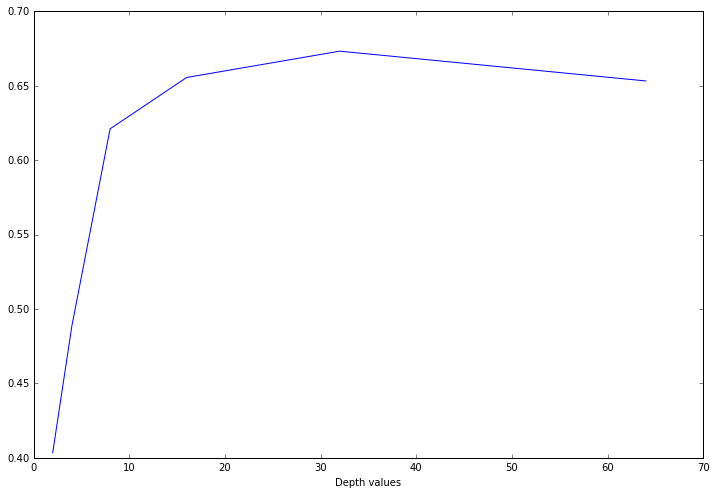

In [67]:
plt.figure(figsize=(12,8))
plt.xlabel("Depth values")
plt.plot(max_depth, scores_depth);

Теперь зафиксируем значения всех параметров, кроме ***max_features*** и так же посмотрим на график зависимости качества от значений этого параметра

In [68]:
max_features = np.arange(1,5)
scores_features = list()
for features in max_features:
    rfc_t = RandomForestClassifier(n_estimators=100, class_weight ='balanced', 
                                   max_depth = 32, max_features = features, criterion='gini')
    rfc_t.fit(X_train_f, y_train)
    rfc_t_predict = rfc_t.predict(X_test_f)
    scores_features.append(f1_score(y_test, rfc_t_predict, average="weighted"))

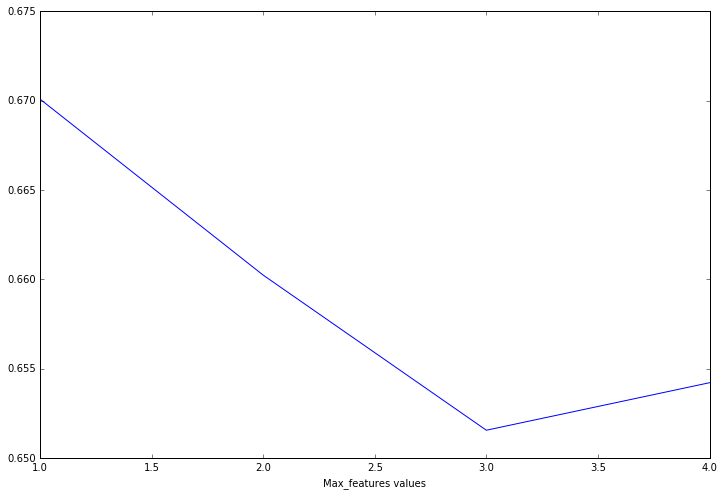

In [70]:
plt.figure(figsize=(12,8))
plt.xlabel("Max_features values")
plt.plot(max_features, scores_features);

**7.** Эмпирически установлено, что при увеличении числа деревьев качество не ухудшается. Проверим это утверждение. Постройте график зависимости качества на тестовой выборке от числа деревьев (n_estimators).

Вам нужно будет перебрать значения до 3000 деревьев (например, с шагом 10: 10, 20, 30, ..., 3000) посчитать качество на тестовой выборке и построить график.

Конечно, для этого можно каждый раз обучать RandomForest с нуля. Однако в таком случае придётся обучить в общей сумме $10 + 20 + \ldots + 3000 = 451500$ деревьев.

Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 3000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно будет указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

In [71]:
# your code here
grid_warm = RandomForestClassifier(warm_start=True, class_weight = grid.best_params_['class_weight'], 
                                  criterion = grid.best_params_['criterion'], max_depth = grid.best_params_['max_depth'],
                                  max_features = grid.best_params_['max_features'])
n_trees = 10
scores = list()
while n_trees != 3000:
    grid_warm.set_params(n_estimators = n_trees)
    grid_warm.fit(X_train_f, y_train)
    predict_warm = grid_warm.predict(X_test_f)
    f_scr = f1_score(y_test, predict_warm, average="weighted")
    scores.append(f_scr);
    n_trees += 10

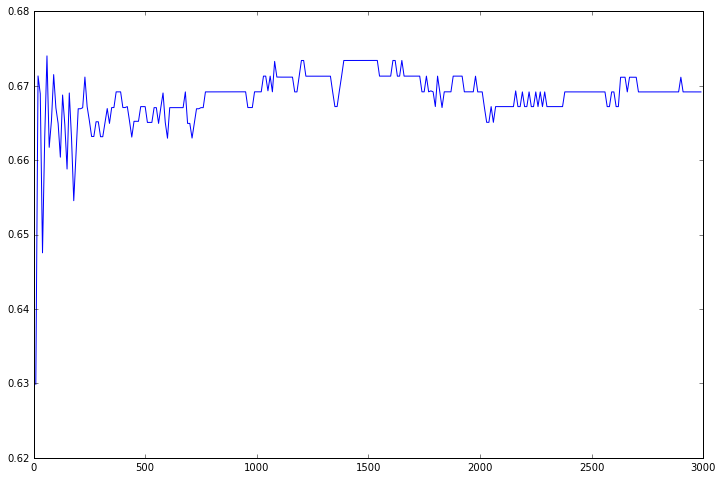

In [72]:
trees = np.arange(10, 3000, 10)
plt.figure(figsize=(12,8))
plt.plot(trees, scores);

**8.** Проверьте, что результат работы RandomForest не зависит от нормировки признаков. Для этого отнормируйте каждый признак, обучите RF и сравните результаты.

In [73]:
from sklearn.preprocessing import StandardScaler

# your code here
sclr = StandardScaler()
X_train_scaled = sclr.fit_transform(X_train_f)
X_test_scaled = sclr.transform(X_test_f)

In [74]:
rfc_f_s= RandomForestClassifier()
rfc_f_s.fit(X_train_scaled, y_train);

rfc_f_s_predict = rfc_f_s.predict(X_test_scaled)
f1_scr_s = f1_score(y_test, rfc_f_s_predict, average="weighted")
print ("New score:", f1_scr_s)
print ("Old score:", f1_scr_f)

New score: 0.632139647117
Old score: 0.61567509543


**9.** Сделайте выводы о том, насколько сильно выбор параметров влияет на работу случайных лесов. Ответьте на вопрос, какую существенную особенность данных мы не учли при построении алгоритма?

При обучении случайных лесов, необходимо верно осуществить подбор параметров. На примере данной работы мы увидели как сильно может меняется точность предсказания при изменении значений параметров, так же леса склонны к переобучению. При построении алгоритма мы не учли балансировку классов.